# keras embedding을 이용한 문서 분류
### 영화리뷰 데이터 대상

In [1]:
from nltk.corpus import movie_reviews
fileids = movie_reviews.fileids() #movie review data에서 file id를 가져옴
reviews = [movie_reviews.raw(fileid) for fileid in fileids] #file id를 이용해 raw text file을 가져옴
categories = [movie_reviews.categories(fileid)[0] for fileid in fileids] 
#file id를 이용해 label로 사용할 category 즉 positive와 negative 정보를 순서대로 가져옴

print('Reviews count:', len(reviews))
print('Length of the first review:', len(reviews[0]))
print('Labels:', set(categories))

Reviews count: 2000
Length of the first review: 4043
Labels: {'neg', 'pos'}


In [2]:
from keras.preprocessing.text import Tokenizer

max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(reviews)

X = tokenizer.texts_to_sequences(reviews)
# 일반적으로 0이면 unknown, 즉 전체단어의 수가 10000개 - num_words가 넘을 경우, index가 10000-1(for unknown)을 넘어가는 단어는 0으로 처리함
#onehot_train = tokenizer.texts_to_matrix(X_train, mode='binary')

print('num of tokens:', len(tokenizer.word_index))

Using TensorFlow backend.


num of tokens: 43296


In [3]:
bow = tokenizer.texts_to_matrix(reviews, mode='binary')
bow.shape

(2000, 10000)

In [4]:
from keras import preprocessing

maxlen = 500

X = preprocessing.sequence.pad_sequences(X, maxlen=maxlen, truncating='pre')
print(X[0])

[  38    1  328   52   20  769   52   20   52   20    2    4  910  114
   52   20 5277    4 1386  171    8  632    3   63    4    9    6  321
   25 1957  143   18 2926  120  301  254    5 9489    2   15  150  143
    3  102   16   44   35    9   91    6  256  103    1  164 2851  100
    3  100  208   18   72  259    4 4077   42   82    2   94   45    6
   14  247  954  353   37  613  294   14  133  801    5 3146   16    9
  138    5  257    5 3146    9  308  313   64  369  493  226    3   75
   36   86  171  439 2795   46   56 1747    7    1 5675   25   92    1
 1280  204    6    8    1 4078    3   18  158 5676   19 1711   38   14
   39   62  175 4079   63    4    9   40   21    1  268   84  212   39
   35    4    1   82    8  197  442    5   86    2   98  251    4  261
   16    9  137  248    1   86    1   15   35    8   43  439   18  618
    1 1486  311   11  121   38   14    6    8   34  167  245   86  276
    8    1  161    6   55    9   56  141   36   20  284    1  801    5
 2016 

In [5]:
label_dict = {'pos':0, 'neg':1}
y = [label_dict[c] for c in categories]
print(y[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [6]:
from sklearn.model_selection import train_test_split #sklearn에서 제공하는 split 함수를 사용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
# sklearn의 train_test_split 함수는 먼저 data set을 shuffle하고 주어진 비율에 따라 train set과 test set을 나눠 줌
# 위에서는 reviews를 X_train과 X_test로 8:2의 비율로 나누고, categories를 y_train과 y_test로 나눔
# 이 때 X와 y의 순서는 동일하게 유지해서 각 입력값과 label이 정확하게 match되도록 함
# random_state는 shuffle에서의 seed 값으로, 지정한 경우 항상 동일한 결과로 shuffle이 됨

print('Train set count:', len(X_train))
print('Test set count:', len(X_test))
print('Test samples:', y_test[:20])

Train set count: 1600
Test set count: 400
Test samples: [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]


In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16001     
Total params: 336,001
Trainable params: 336,001
Non-trainable params: 0
_________________________________________________________________
Train on 1280 samples, validate on 320 samples
Epoch 1/30
1280/1280 [==============================] - 1s 601us/step - loss: 0.6922 - acc: 0.5320 - val_loss: 0.6920 - val_acc: 0.5281
Epoch 2/30
1280/1280 [==============================] - 0s 168us/step - loss: 0.6398 - acc: 0.8820 - val_loss: 0.6901 - val_acc: 0.5469
Epoch 3/30
1280/1280 [==============================] - 0s 212us/step - loss: 0.5

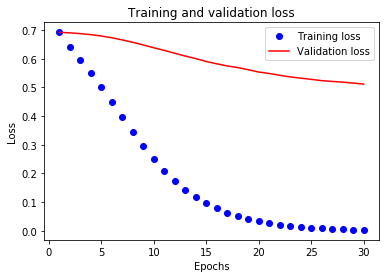

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [9]:
score = model.evaluate(X_test, y_test)
print(score)

400/400 [==============================] - 0s 95us/step
[0.5425681495666503, 0.73]


In [10]:
from keras.layers import SimpleRNN, LSTM

model = Sequential()
model.add(Embedding(max_words, 32))
#model.add(SimpleRNN(32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2)

Train on 1280 samples, validate on 320 samples
Epoch 1/30
1280/1280 [==============================] - 8s 6ms/step - loss: 0.6934 - acc: 0.4891 - val_loss: 0.6926 - val_acc: 0.5469
Epoch 2/30
1280/1280 [==============================] - 6s 4ms/step - loss: 0.6898 - acc: 0.6969 - val_loss: 0.6912 - val_acc: 0.5656
Epoch 3/30
1280/1280 [==============================] - 6s 4ms/step - loss: 0.6814 - acc: 0.7836 - val_loss: 0.6864 - val_acc: 0.5969
Epoch 4/30
1280/1280 [==============================] - 6s 5ms/step - loss: 0.6473 - acc: 0.8000 - val_loss: 0.6561 - val_acc: 0.5594
Epoch 5/30
1280/1280 [==============================] - 6s 5ms/step - loss: 0.6851 - acc: 0.6711 - val_loss: 0.6585 - val_acc: 0.6156
Epoch 6/30
1280/1280 [==============================] - 7s 5ms/step - loss: 0.5711 - acc: 0.8500 - val_loss: 0.6014 - val_acc: 0.7438
Epoch 7/30
1280/1280 [==============================] - 6s 5ms/step - loss: 0.4958 - acc: 0.8187 - val_loss: 0.5478 - val_acc: 0.7812
Epoch 8/30
1280

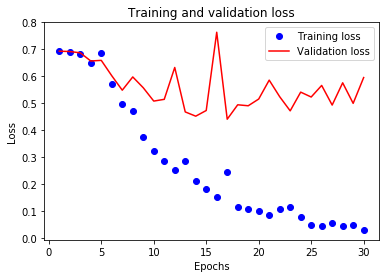

In [12]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

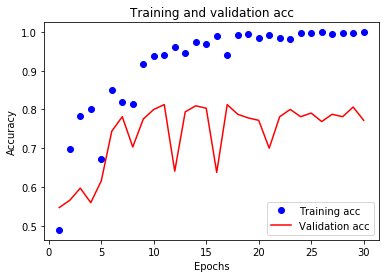

In [13]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [14]:
score = model.evaluate(X_test, y_test)
print(score)

400/400 [==============================] - 1s 2ms/step
[0.5971889805793762, 0.78]


#### 문제점: train set의 크기가 너무 작다
해결방안: train set을 충분히 늘리거나, pre-trained embedding vector를 사용

## pre-trained embedding을 사용
GloVe: https://nlp.stanford.edu/projects/glove <br>
다운 받아서 datasets 폴더 안에 압축을 풀고 그 중에서 glove.6B.100d.txt를 사용<br>

파일 안의 모양: 단어 + 단어의 100차원 vector 집합으로 이루어져 있음<br>

예) the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062

한 라인은 하나의 단어와 그 단어의 vector로 이루어져 있으므로, 각 라인에 대해 첫 token을 word로, 나머지 100 token을 vector로 변환하면 됨 

In [15]:
glove_dir = './datasets/'
import os
import numpy as np

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Num of word vectors:', len(embeddings_index))

Num of word vectors: 400000


In [16]:
# 처음 데이터를 생성할 때 사용한 tokenizer에서 word_index를 추출
# 이 word_index에 맞게 glove로부터 해당하는 word vector를 가져옴
word_index = tokenizer.word_index
len(word_index)

43296

In [17]:
#embedding matrix를 생성: word_index에서 max_words 만큼의 단어에 대해 glove의 embeddings_index를 추출하여 matrix 생성
#추출한 matrix는 embedding 층의 weight로 고정해서 사용함

embedding_dim = 100 # glove의 vector dimension
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [45]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers import SimpleRNN, LSTM

model = Sequential()
model.add(Embedding(max_words, embedding_dim))
#model.add(SimpleRNN(32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

In [46]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False #값을 고정
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,017,057
Trainable params: 17,057
Non-trainable params: 1,000,000
_________________________________________________________________


In [39]:
from keras import optimizers
#rmsprop = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0) #default lr은 0.001
#rmsprop = optimizers.RMSprop(lr=0.005) #default lr은 0.001
adam = optimizers.Adam(lr=0.005) #default lr은 0.001

# pre-train이 되어 있으므로 적은 수의 test set으로도 학습이 가능
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2) 
#model.save_weights('pre_trained_glove_model.h5')

Train on 1280 samples, validate on 320 samples
Epoch 1/30
1280/1280 [==============================] - 21s 16ms/step - loss: 0.7081 - acc: 0.5094 - val_loss: 0.6762 - val_acc: 0.5969
Epoch 2/30
1280/1280 [==============================] - 17s 13ms/step - loss: 0.6763 - acc: 0.5867 - val_loss: 0.6706 - val_acc: 0.6031
Epoch 3/30
1280/1280 [==============================] - 16s 12ms/step - loss: 0.6639 - acc: 0.6141 - val_loss: 0.6627 - val_acc: 0.6094
Epoch 4/30
1280/1280 [==============================] - 16s 12ms/step - loss: 0.6474 - acc: 0.6328 - val_loss: 0.6516 - val_acc: 0.6125
Epoch 5/30
1280/1280 [==============================] - 16s 13ms/step - loss: 0.6200 - acc: 0.6617 - val_loss: 0.6263 - val_acc: 0.6250
Epoch 6/30
1280/1280 [==============================] - 16s 12ms/step - loss: 0.5899 - acc: 0.6953 - val_loss: 0.5867 - val_acc: 0.7031
Epoch 7/30
1280/1280 [==============================] - 15s 12ms/step - loss: 0.6062 - acc: 0.6703 - val_loss: 0.6382 - val_acc: 0.6344
E

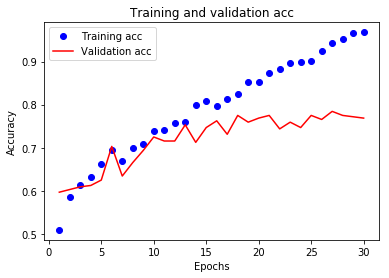

In [40]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [41]:
score = model.evaluate(X_test, y_test)
print(score)

400/400 [==============================] - 1s 3ms/step
[0.6689890551567078, 0.75]


### glove를 사용하지 않으면서 좀 더 정교한 모형을 사용하여 학습
optimizer를 정교하게 조정하고, regularizer를 추가

In [55]:
from keras.layers import SimpleRNN, LSTM
from keras import regularizers

model = Sequential()
model.add(Embedding(max_words, 32))
#model.add(SimpleRNN(32))
model.add(LSTM(32))
#model.add(Dense(32, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.1))) #0.01을 먼저 시도했음

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras import optimizers
#adam = optimizers.Adam(lr=0.005) #default lr은 0.001
rmsprop = optimizers.RMSprop(lr=0.005) #default lr은 0.001

model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['acc']) 
#lr 조절 없고 l2=0.01일 때 test 0.775 나옴

history = model.fit(X_train, y_train, 
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2) 

Train on 1280 samples, validate on 320 samples
Epoch 1/30
1280/1280 [==============================] - 21s 16ms/step - loss: 0.8390 - acc: 0.5266 - val_loss: 0.8264 - val_acc: 0.5531
Epoch 2/30
1280/1280 [==============================] - 14s 11ms/step - loss: 0.7396 - acc: 0.6773 - val_loss: 0.7496 - val_acc: 0.6281
Epoch 3/30
1280/1280 [==============================] - 14s 11ms/step - loss: 0.7657 - acc: 0.7156 - val_loss: 0.6928 - val_acc: 0.6813
Epoch 4/30
1280/1280 [==============================] - 14s 11ms/step - loss: 0.5105 - acc: 0.8625 - val_loss: 0.6900 - val_acc: 0.6687
Epoch 5/30
1280/1280 [==============================] - 14s 11ms/step - loss: 0.3859 - acc: 0.9453 - val_loss: 0.8243 - val_acc: 0.6281
Epoch 6/30
1280/1280 [==============================] - 14s 11ms/step - loss: 0.3817 - acc: 0.9258 - val_loss: 0.6514 - val_acc: 0.7250
Epoch 7/30
1280/1280 [==============================] - 14s 11ms/step - loss: 0.2979 - acc: 0.9609 - val_loss: 0.6715 - val_acc: 0.7188
E

In [54]:
score = model.evaluate(X_test, y_test)
print(score)

400/400 [==============================] - 1s 2ms/step
[0.5831045365333557, 0.775]
